This notebook provides a demo for the use of **DeepSpeech Distances** proposed in [High Fidelity Speech Synthesis with Adversarial Networks](https://arxiv.org/abs/1909.11646) as new evaluation metrics for neural speech synthesis.

The computation involves estimating Fréchet and Kernel distances between high-level features of the reference and the examined samples extracted from [NVIDIA's DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html) model.

We propose four distances:


*   *Fréchet DeepSpeech Distance* (*FDSD*, based on FID, see [2])
*   *Kernel DeepSpeech Distance* (*KDSD*, based on KID, see [3])
*   *conditional Fréchet DeepSpeech Distance* (*cFDSD*),
*   *conditional Kernel DeepSpeech Distance* (*cKDSD*).

The conditional distances compare samples with the same conditioning (e.g. text) and asses conditional quality of the audio. The uncoditional ones compare random samples from two distributions and asses general quality of audio. For more details, see [1].

**References**

[1] Mikołaj Bińkowski, Jeff Donahue, Sander Dieleman, Aidan Clark, Erich Elsen, Norman Casagrande, Luis C. Cobo, Karen Simonyan, [*High Fidelity Speech Synthesis with Adversarial Networks*](https://arxiv.org/abs/1909.11646), ICLR 2020.

[2] Martin Heusel, Hubert Ramsauer, Thomas Unterthiner, Bernhard Nessler, Sepp Hochreiter, [*GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium*](https://arxiv.org/abs/1706.08500), NeurIPS 2017.

[3] Mikołaj Bińkowski, Dougal J. Sutherland, Michael Arbel, Arthur Gretton, [*Demystifying MMD GANs*](https://arxiv.org/abs/1801.01401), ICLR 2018.


**Demo**

Firsty, install dependencies and download the checkpoint of the pretrained DeepSpeech2 model.

In [0]:
!pip install python_speech_features
!pip install resampy
!pip install scipy
!pip install gdown
!pip install tqdm -U

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.42.1)


Set up evaluation parameters and paths within the mounted Google Drive. Clone repository and download checkpoint.

In [0]:
PATH = '/content/drive/My Drive/DeepSpeechDistances'
SAMPLE_PATH = '/content/drive/My Drive/DeepSpeechDistances/abstract_samples'
NUM_SPLITS = 3  # number of data splits to comute std of DSD
SAMPLES_PER_SPLIT = 500  # number of samples in a single DSD run. 
# We recommend at least 10k samples for evaluation to get reasonable estimates.
AUDIO_LENGTH = 2  # length of individual sample, in seconds
NUM_NOISE_LEVELS = 3  # number of different noise levels for samples to evaluate

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import sys, os
sh = lambda path: "'" + path + "'"

if not os.path.exists(PATH):
  !git clone https://github.com/mbinkowski/DeepSpeechDistances.git {sh(PATH)}
else:
  print('Found DeepSpeechDistances directory, skipping git clone.')
sys.path.append(PATH)

if not os.path.exists(os.path.join(PATH, 'checkpoint', 'ds2_large')):
  CKPT = sh(PATH + '/ds2.tar.gz')
  !gdown https://drive.google.com/uc?id=1EDvL9wMCO2vVE-ynBvpwkFTultbzLNQX -O {CKPT}
  !tar -C {sh(PATH +'/checkpoint/')} -xvf {CKPT}
  !rm {CKPT}
else:
  print('Found checkpoint directory, skipping download.')

Mounted at /content/drive/
Cloning into '/content/drive/My Drive/DeepSpeechDistances'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 171 (delta 104), reused 88 (delta 41), pack-reused 0
Receiving objects: 100% (171/171), 3.03 MiB | 6.03 MiB/s, done.
Resolving deltas: 100% (104/104), done.
Downloading...
From: https://drive.google.com/uc?id=1EDvL9wMCO2vVE-ynBvpwkFTultbzLNQX
To: /content/drive/My Drive/DeepSpeechDistances/ds2.tar.gz
1.01GB [00:05, 199MB/s]
ds2_large/
ds2_large/checkpoint
ds2_large/model.ckpt-54800.index
ds2_large/model.ckpt-54800.data-00000-of-00001
ds2_large/model.ckpt-54800.meta


Do other necessary imports.

In [0]:
%tensorflow_version 1.x
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import audio_distance
from sample_utils import subsample_audio

Create random 2-second samples from source audio file. 

By default, we use our generated abstract ([1]) as a source of both clean reference samples and noise-corrupted samples for examination.

User can specify other audio files; in principle, DeepSpeech Distances require reference samples (e.g. real speech) and samples to be examined, all of the sample length. Although this demo uses a smaller number for the sake of fast computation, we suggest using at least 10,000 samples per each set, to obtain good estimates of the distances.

In [0]:
subsample_audio(os.path.join(PATH, 'abstract.wav'), 
                SAMPLE_PATH,
                num_samples=NUM_SPLITS * SAMPLES_PER_SPLIT,
                length=AUDIO_LENGTH,
                num_noise_levels=NUM_NOISE_LEVELS)

Saving audio sample files: 100%|██████████| 3000/3000 [02:22<00:00, 21.04it/s]


Create evaluator object and load reference samples.

In [0]:
reference_path = os.path.join(SAMPLE_PATH, 'ref', '*.wav')
eval_paths = [os.path.join(SAMPLE_PATH, f'noisy_{i+1}', '*.wav') for i
              in range(NUM_NOISE_LEVELS)]

evaluator = audio_distance.AudioDistance(
    load_path=os.path.join(PATH, 'checkpoint', 'ds2_large', 'model.ckpt-54800'),
    meta_path=os.path.join(PATH, 'checkpoint', 'collection-stripped-meta.meta'),
    required_sample_size=NUM_SPLITS * SAMPLES_PER_SPLIT,
    num_splits=NUM_SPLITS)

evaluator.load_real_data(reference_path)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Carry out distance estimation.

In [0]:
dist_names = ['FDSD', 'KDSD', 'cFDSD', 'cKDSD']
def print_results(values):
  print('\n' + ', '.join(['%s = %.5f (%.5f)' % (n, v[0], v[1]) for n, v 
                          in zip(dist_names, values)]))

with tf.Session(config=evaluator.sess_config) as sess:
  print('Computing reference DeepSpeech distances.')
  values = evaluator.get_distance(sess=sess)
  print_results(values)
  distances = [values]

  for eval_path in eval_paths:
    print('\nComputing DeepSpeech distances for files in the directory:\n'
          + os.path.dirname(eval_path))
    values = evaluator.get_distance(sess=sess, files=eval_path)
    print_results(values)
    distances.append(values)

Computing reference DeepSpeech distances.
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/DeepSpeechDistances/checkpoint/ds2_large/model.ckpt-54800


Extracting DeepSpeech features from reference samples:   0%|          | 0/2976 [00:00<?, ?it/s]

Checkpoint restored.


Extracting DeepSpeech features from reference samples: 100%|██████████| 2976/2976 [02:40<00:00, 18.53it/s]
Extracting DeepSpeech features from samples to evaluate:   0%|          | 0/1488 [00:00<?, ?it/s]

DeepSpeech2: finished evaluating features, total time%.1fs 160.58556151390076


Extracting DeepSpeech features from samples to evaluate: 100%|██████████| 1488/1488 [01:18<00:00, 18.87it/s]


DeepSpeech2: finished evaluating features, total time%.1fs 78.86826682090759
AudioDistance: got features from both samples, computing metrics...
AudioDistance: computed metrics from features in %.1fs. 6.669249534606934
Evaluation with the same conditioning.


Extracting DeepSpeech features from samples to evaluate:   0%|          | 0/1488 [00:00<?, ?it/s]

AudioDistance: computed metrics from features in %.1fs. 3.8303287029266357
AudioDistance: finished evaluation.

FDSD = 0.95414 (0.07864), KDSD = -0.00002 (0.00002), cFDSD = 0.00005 (0.00002), cKDSD = -0.00008 (0.00000)

Computing DeepSpeech distances for files in the directory:
/content/drive/My Drive/DeepSpeechDistances/abstract_samples/noisy_1


Extracting DeepSpeech features from samples to evaluate: 100%|██████████| 1488/1488 [01:17<00:00, 19.29it/s]


DeepSpeech2: finished evaluating features, total time%.1fs 77.15188503265381
AudioDistance: got features from both samples, computing metrics...
AudioDistance: computed metrics from features in %.1fs. 3.8056063652038574
Evaluation with the same conditioning.


Extracting DeepSpeech features from samples to evaluate:   0%|          | 0/1488 [00:00<?, ?it/s]

AudioDistance: computed metrics from features in %.1fs. 3.8733911514282227
AudioDistance: finished evaluation.

FDSD = 1.06858 (0.10391), KDSD = 0.00001 (0.00004), cFDSD = 0.18677 (0.01912), cKDSD = -0.00007 (0.00000)

Computing DeepSpeech distances for files in the directory:
/content/drive/My Drive/DeepSpeechDistances/abstract_samples/noisy_2


Extracting DeepSpeech features from samples to evaluate: 100%|██████████| 1488/1488 [01:16<00:00, 19.37it/s]


DeepSpeech2: finished evaluating features, total time%.1fs 76.84328842163086
AudioDistance: got features from both samples, computing metrics...
AudioDistance: computed metrics from features in %.1fs. 3.8479652404785156
Evaluation with the same conditioning.


Extracting DeepSpeech features from samples to evaluate:   0%|          | 0/1488 [00:00<?, ?it/s]

AudioDistance: computed metrics from features in %.1fs. 3.898447036743164
AudioDistance: finished evaluation.

FDSD = 1.71981 (0.08992), KDSD = 0.00043 (0.00009), cFDSD = 1.13086 (0.01851), cKDSD = 0.00042 (0.00000)

Computing DeepSpeech distances for files in the directory:
/content/drive/My Drive/DeepSpeechDistances/abstract_samples/noisy_3


Extracting DeepSpeech features from samples to evaluate: 100%|██████████| 1488/1488 [01:17<00:00, 19.25it/s]


DeepSpeech2: finished evaluating features, total time%.1fs 77.31380581855774
AudioDistance: got features from both samples, computing metrics...
AudioDistance: computed metrics from features in %.1fs. 3.808804512023926
Evaluation with the same conditioning.
AudioDistance: computed metrics from features in %.1fs. 3.855832815170288
AudioDistance: finished evaluation.

FDSD = 22.65459 (0.31955), KDSD = 0.03375 (0.00090), cFDSD = 22.91773 (0.14217), cKDSD = 0.03420 (0.00029)


Plot results.
Kernel distances usually give similar numbers (which, in case of small samples, might be negative due to unbiased estimator of MMD). Unconditional Frechet distance differs significantly from the conditional one for reference samples and always gives positive values due to biased estimator.

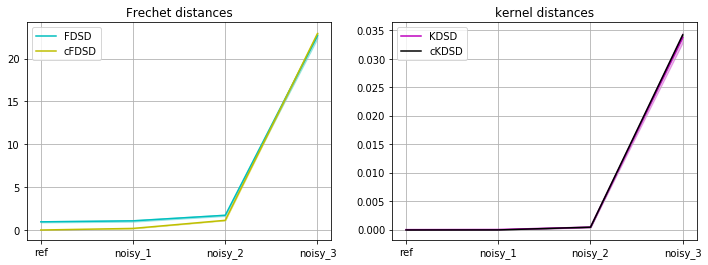

In [0]:
all_paths = [reference_path] + eval_paths
prefix_len = len(os.path.commonpath(all_paths))
sample_names = [path[prefix_len + 1:] for path in all_paths]
if all([os.path.basename(p) == '*.wav' for p in all_paths]):
  sample_names = [name[:-6] for name in sample_names]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
x = range(NUM_NOISE_LEVELS + 1)
for i, kind in enumerate(['Frechet', 'kernel']):
  ax[i].set_title(kind + ' distances')
  ax[i].set_xticks(x)
  ax[i].set_xticklabels(sample_names)
  for j in [0, 2]:
    k = i + j
    ax[i].plot(x, [d[k][0] for d in distances], color='cmyk'[k],
               label=dist_names[k])
    ax[i].fill_between(x, [d[k][0] - d[k][1] for d in distances],
                       [d[k][0] + d[k][1] for d in distances], color='cmyk'[k],
                       alpha=.3)
  ax[i].legend()
  ax[i].grid()  

In [0]:
drive.flush_and_unmount()